# 📘 Projeto Telecom X – Parte 2: Prevendo Churn
Este notebook contém todas as etapas do projeto de previsão de evasão de clientes da Telecom X, incluindo pré-processamento, modelagem, avaliação e análise estratégica.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

sns.set(style="whitegrid")


## 📂 Carregamento e Tratamento Inicial dos Dados

In [10]:
# Carregar dados tratados do desafio anterior
df = pd.read_json("TelecomX_Data-2.json")

# Expandir colunas aninhadas
df_expanded = pd.concat([
    df.drop(columns=["customer", "phone", "internet", "account"]),
    df["customer"].apply(pd.Series),
    df["phone"].apply(pd.Series),
    df["internet"].apply(pd.Series),
    df["account"].apply(pd.Series)
], axis=1)

# Eliminar coluna de ID
df_expanded = df_expanded.drop(columns=["customerID"])

# Separar 'Charges' em duas colunas numéricas
charges_df = df_expanded["Charges"].apply(pd.Series)
charges_df["Total"] = pd.to_numeric(charges_df["Total"], errors='coerce')
charges_df["Monthly"] = pd.to_numeric(charges_df["Monthly"], errors='coerce')
df_final = pd.concat([df_expanded.drop(columns=["Charges"]), charges_df], axis=1)

# Codificação das variáveis
df_encoded = pd.get_dummies(df_final.drop(columns=["Churn"]), drop_first=True)
df_encoded["Churn"] = df_final["Churn"].map({"Yes": 1, "No": 0})


## 📈 Análise de Correlação

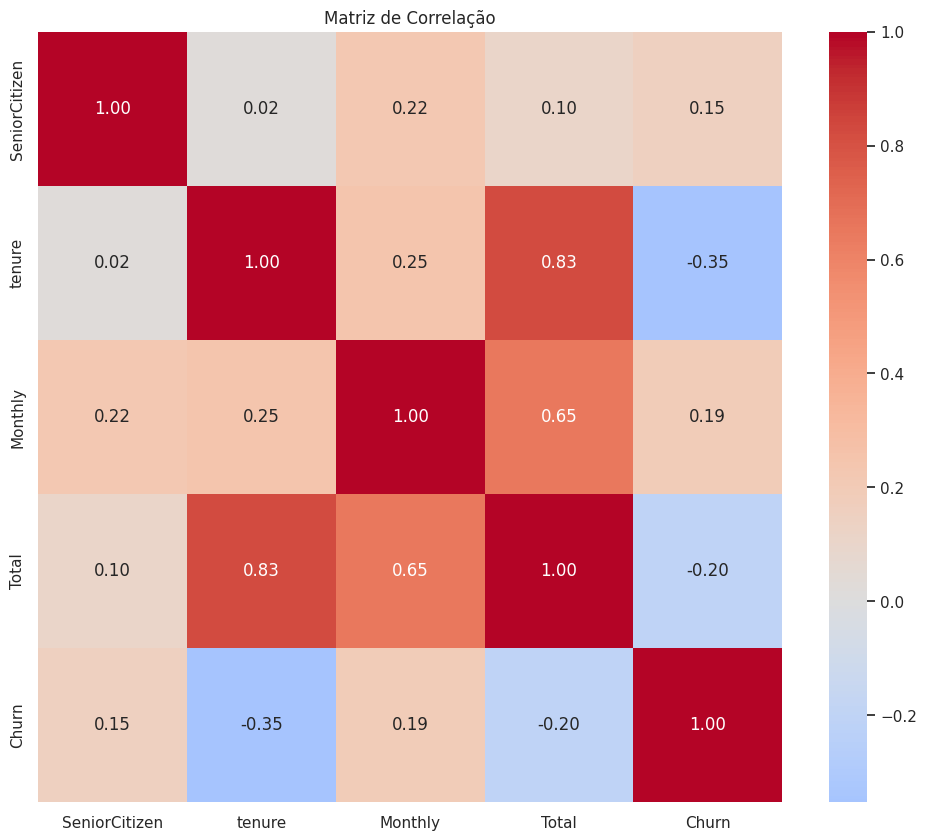

In [11]:
numeric_df = df_encoded.select_dtypes(include=["int64", "float64"])
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Matriz de Correlação")
plt.show()

## 🔍 Padrões entre Variáveis e Churn

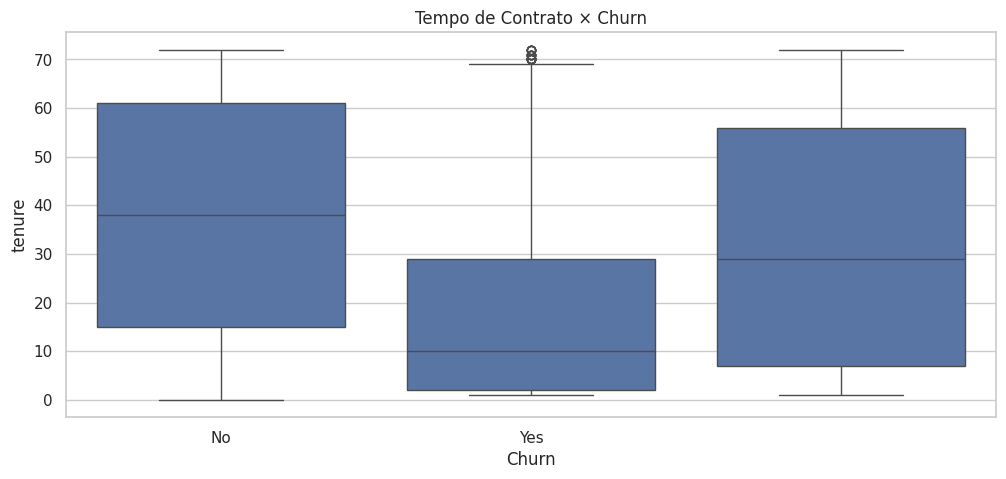

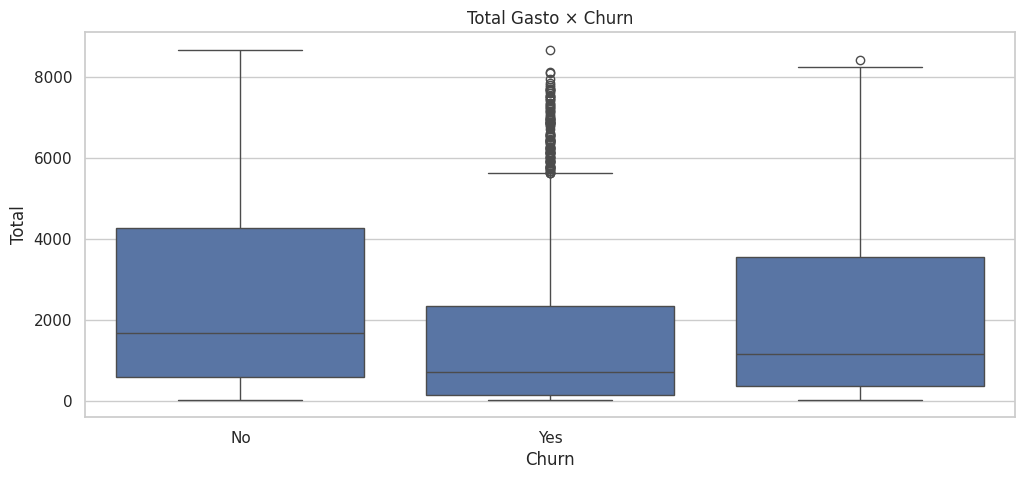

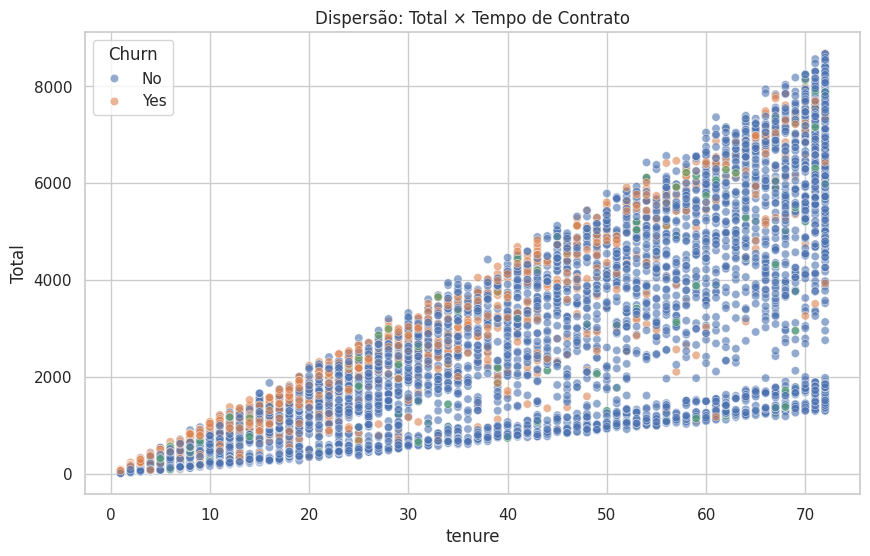

In [12]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="Churn", y="tenure", data=df_final)
plt.title("Tempo de Contrato × Churn")
plt.show()

print("\n")  # Espaço visual no notebook

plt.figure(figsize=(12, 5))
sns.boxplot(x="Churn", y="Total", data=df_final)
plt.title("Total Gasto × Churn")
plt.show()

print("\n")  # Espaço visual no notebook

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x="tenure", y="Total", hue="Churn", alpha=0.6)
plt.title("Dispersão: Total × Tempo de Contrato")
plt.show()

## 🧪 Divisão dos Dados e Pré-processamento

In [13]:
df_encoded = df_encoded.dropna(subset=["Churn"])
X = df_encoded.drop(columns=["Churn"])
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Imputar valores faltantes
imputer = SimpleImputer(strategy="mean")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Normalizar para modelos sensíveis à escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)


## 🧠 Treinamento dos Modelos

In [14]:
modelo_log = LogisticRegression(max_iter=1000, random_state=42)
modelo_log.fit(X_train_scaled, y_train)

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_imp, y_train)

RandomForestClassifier(random_state=42)

## 📊 Avaliação dos Modelos


📌 Avaliação - Regressão Logística
Acurácia: 0.7942
Precisão: 0.6373
Recall: 0.5214
F1-Score: 0.5735

               precision    recall  f1-score   support

         0.0       0.84      0.89      0.86      1035
         1.0       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



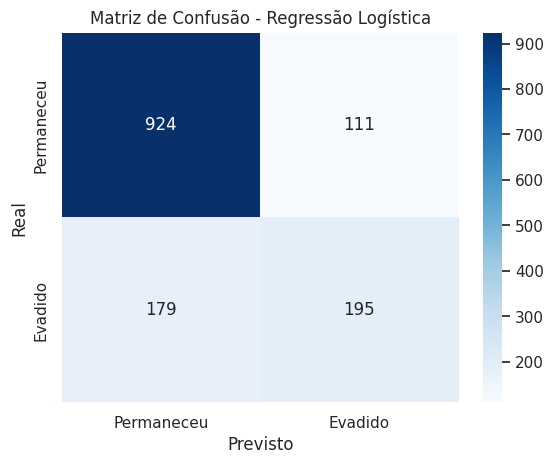


📌 Avaliação - Random Forest
Acurácia: 0.7913
Precisão: 0.6370
Recall: 0.4973
F1-Score: 0.5586

               precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      1035
         1.0       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



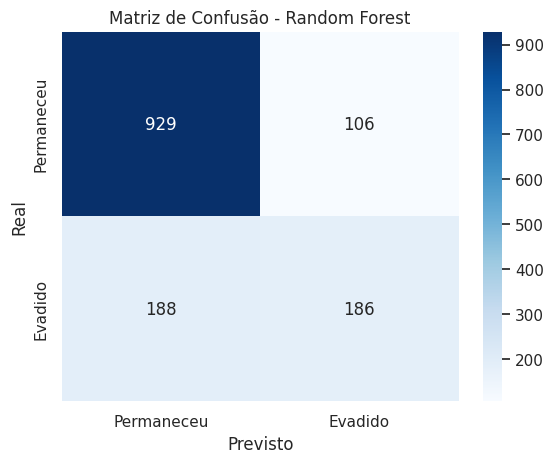

In [15]:
def avaliar_modelo(nome, modelo, X_teste, y_teste):
    y_pred = modelo.predict(X_teste)
    print(f"\n📌 Avaliação - {nome}")
    print(f"Acurácia: {accuracy_score(y_teste, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_teste, y_pred):.4f}")
    print(f"Recall: {recall_score(y_teste, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_teste, y_pred):.4f}")
    print("\n", classification_report(y_teste, y_pred))
    cm = confusion_matrix(y_teste, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Permaneceu", "Evadido"], yticklabels=["Permaneceu", "Evadido"])
    plt.title(f"Matriz de Confusão - {nome}")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.show()

avaliar_modelo("Regressão Logística", modelo_log, X_test_scaled, y_test)
avaliar_modelo("Random Forest", modelo_rf, X_test_imp, y_test)

## 🌟 Importância das Variáveis

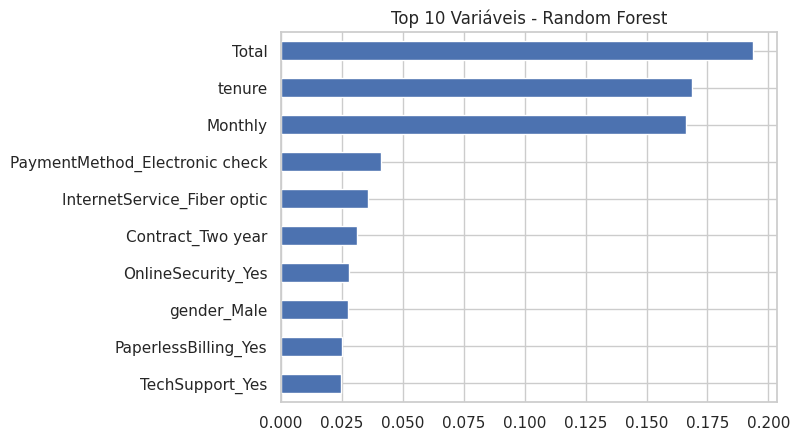

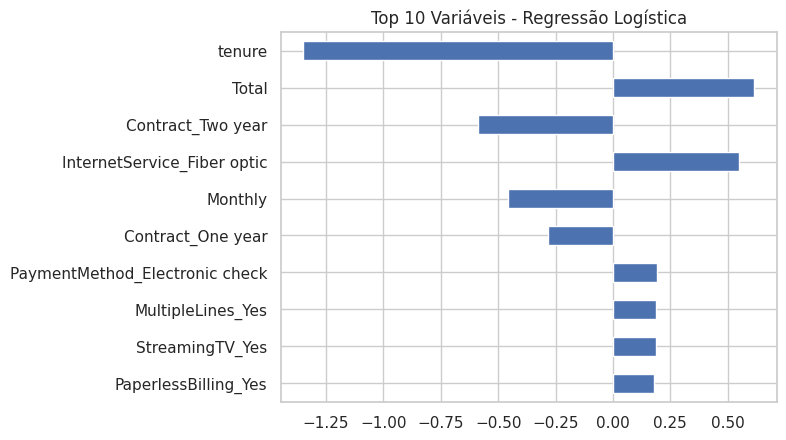

In [16]:
importances_rf = modelo_rf.feature_importances_
importancias = pd.Series(importances_rf, index=X.columns).sort_values(ascending=False)
importancias.head(10).plot(kind='barh', title="Top 10 Variáveis - Random Forest")
plt.gca().invert_yaxis()
plt.show()

print("\n")  # Espaço visual no notebook

coef_log = pd.Series(modelo_log.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
coef_log.head(10).plot(kind='barh', title="Top 10 Variáveis - Regressão Logística")
plt.gca().invert_yaxis()
plt.show()

## ✅ Conclusão Estratégica
- Os modelos treinados apresentaram desempenho equilibrado, com destaque para a Regressão Logística no recall.
- Variáveis como `tenure`, `Monthly`, `Total`, `Contract`, e `InternetService_Fiber optic` mostraram forte influência na evasão.
- Estratégias de fidelização e suporte proativo devem ser priorizadas para clientes com alta mensalidade, contratos curtos e menor tempo de casa.

## 📘 Relatório Final – Previsão de Evasão de Clientes (Churn) – Telecom X

### 👨‍💻 Projeto: Prevendo Churn – Parte 2  
**Objetivo:** Prever quais clientes têm maior chance de cancelar seus serviços (churn), utilizando modelos preditivos e análise de variáveis relevantes.

---

### 🔍 Resumo do Processo

1. **Pré-processamento**
   - Eliminação de colunas irrelevantes (ex: ID do cliente).
   - One-hot encoding aplicado às variáveis categóricas.
   - Normalização aplicada para modelos sensíveis à escala (Regressão Logística).
   - Imputação de valores faltantes via média.

2. **Modelos Treinados**
   - **Regressão Logística** (com normalização)
   - **Random Forest Classifier** (sem normalização)

---

### 📊 Desempenho dos Modelos

| Métrica       | Regressão Logística | Random Forest |
|---------------|---------------------|----------------|
| Acurácia      | 79,42%              | 79,13%         |
| Precisão      | 63,73%              | 63,70%         |
| Recall        | 52,14%              | 49,73%         |
| F1-Score      | **57,35%**          | 55,86%         |

---

### 🧠 Principais Fatores que Influenciam a Evasão

| Fator                           | Influência no Churn         |
|----------------------------------|-----------------------------|
| **Tempo como cliente (tenure)** | Quanto menor o tempo, maior o risco de evasão |
| **Fatura mensal (Monthly)**     | Faturas mais altas aumentam a evasão |
| **Total gasto (Total)**         | Clientes com maior gasto acumulado tendem a sair |
| **Tipo de contrato**            | Contratos mensais aumentam o churn; contratos anuais ou bienais reduzem |
| **Serviço de Internet (Fiber)** | Clientes com fibra óptica tendem a sair mais |
| **Suporte técnico e segurança** | Quem tem suporte ou segurança ativa permanece mais |
| **Pagamento por débito direto** | Clientes que pagam por boleto/banco eletrônico têm mais chance de evasão |

---

### 💡 Recomendações Estratégicas para Retenção

1. **Oferecer incentivos para fidelização**  
   ➤ Clientes com contrato mensal devem ser abordados com descontos progressivos para migração a contratos anuais.

2. **Segmentar clientes com faturas altas**
   ➤ Clientes com gastos elevados (Monthly e Total) devem ser monitorados e receber atendimento proativo.

3. **Monitorar usuários de fibra óptica**
   ➤ Investigar causas de insatisfação entre clientes com esse tipo de serviço.

4. **Campanhas de engajamento no início da jornada**
   ➤ A maioria dos churns ocorre nos primeiros meses — é essencial garantir uma excelente experiência inicial.

5. **Facilitar o uso de serviços adicionais (segurança, suporte técnico)**
   ➤ Essas opções demonstraram estar associadas à permanência do cliente.

---

### ✅ Conclusão

Este modelo de previsão de churn permite **identificar com antecedência** quais clientes apresentam risco de evasão, possibilitando à Telecom X aplicar estratégias personalizadas de retenção.  
A combinação de **Regressão Logística** e **Random Forest** trouxe insights valiosos e complementares sobre o comportamento do cliente.

> Com esses dados, a Telecom X está mais preparada para agir de forma preventiva e **reduzir significativamente sua taxa de churn**.
